<a href="https://colab.research.google.com/github/JacobFV/AGI/blob/master/self_organized_criticality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Self-Organized Criticality

### Imports 

In [ ]:
%tensorflow_version 2.x

import math
import tqdm
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

!pip install -q tsalib
import tsalib
import networkx
!pip install -q jplotlib
import jplotlib as jpl
!pip install -q livelossplot
from livelossplot import PlotLossesKeras

import tensorflow as tf
keras = tf.keras
tfkl = keras.layers

import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers
tfb = tfp.bijectors

## [Self-organized criticality in neural networks from activity-based-rewiring](https://arxiv.org/abs/2009.1178)

Let $N=( \mathbf{a}, \mathbf{\bar{a}}, C )$ be a $n$-node network where
- $\mathbf{a} = a_{1,2,\dots,n} \in [0,1]^{b \times n}$ are its node states 
- $\mathbf{\bar{a}} = \bar{a}_{1,2,\dots,n} \in [0,1]^{b \times n}$ are its mean node states 
- $C = \{c_{ij}\} \in [-1, 1]^{n \times n}$ is its connectivity matrix from node $i$ to node $j$

At every time step:
- all nodes update their state by $\mathbf{a}' \sim P(\sigma(\mathbf{a}C))$
- update mean activations $\mathbf{\bar{a}}' = \alpha \mathbf{a} + (1 - \alpha) \mathbf{\bar{a}}$
- one node $j$ is uniformly selected for presynaptic connectivity $C_{:,j}$ update by:
    - if $\bar{a_j} > +1-\epsilon$, randomly make one input $k$ negative $C_{k,j} = -1$
    - if $\bar{a_j} < -1+\epsilon$, randomly make one input $k$ positive $C_{k,j} = +1$
    - otherwise, randomly remove one input $C_{?,j} = 0$

Parameters:
- $n =$ number neurons
- $b =$ batch size
- $\beta \in (0, \infty) =$ inverse temperature. Higher values decrease entropy. 
- $P =$ the Bernoilli distribution
- $\epsilon =$ update threshold
- $\alpha \in [0, 1] =$ mean activation update window

### `update` function

In [ ]:
p = params = dict(n=32, b=1, beta=2, epsilon=0.2, alpha=0.1)

def update(inputs):
    a, a_ave, C = inputs
    
    a = tfp.distributions.Bernoulli(logits=p['beta'] * (a @ C)).sample()
    a = tf.cast(a, tf.float32)
    
    a_ave = p['alpha'] * a + (1 - p['alpha']) * a_ave
    
    js = tf.random.uniform(shape=(p['b'],), minval=0, maxval=p['n'], dtype=tf.int32) # dest nodes
    ks = tf.random.uniform(shape=(p['b'],), minval=0, maxval=p['n'], dtype=tf.int32) # src nodes
    
    for b in tf.range(p['b']):
        j = js[b]
        k = ks[b]
        
        if a_ave[b, j] > +1 - p['epsilon']:
            C[k,j].assign(-1.0)
        elif a_ave[b, j] < p['epsilon']:
            C[k,j].assign(+1.0)
        else:
            C[k,j].assign(0.0)
    
    return (a, a_ave, C)

def loop(data, duration=1000):    
    for _ in tf.range(duration):
        data = update(data)
    return data

100%|██████████| 20/20 [00:09<00:00,  2.21it/s]


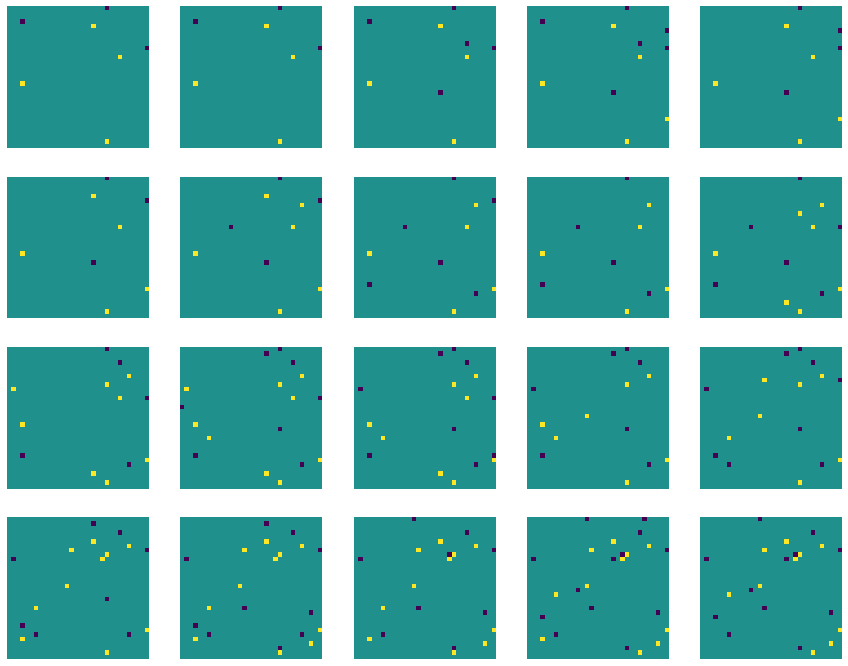

In [ ]:
a = tf.zeros((params['b'], params['n']))
a_ave = tf.zeros((params['b'], params['n']))
C = tf.zeros((params['n'], params['n']))
C = tf.Variable(C)
#C = tf.random.uniform((params['n'], params['n']), minval=-1.0, maxval=1.0)
states = (a, a_ave, C)

T_step = 100
N = 20

N_col = 5
N_row = math.ceil(N / N_col)
fig, axes = plt.subplots(nrows=N_row, ncols=N_col, figsize=(3*N_col, 3*N_row))

for n in tqdm.tqdm(range(N)):
    a, a_ave, C = loop((a, a_ave, C), duration=T_step)
    
    col = n % N_col
    row = n // N_col
    axes[row, col].axis('off')
    axes[row, col].imshow(C)
        
plt.show()

### keras layer

In [ ]:
class CriticalLayer0(tfkl.Layer):
    
    DEFAULT_PARAMS = dict(
        n=None,
        b=None,
        beta=2,
        epsilon=0.2,
        alpha=0.1,
        steps_update=10)
    
    def __init__(self, p=None, **kwargs):
        super(CriticalLayer0, self).__init__(**kwargs)
        
        if p is None:
            p = dict()
        self.p = CriticalLayer0.DEFAULT_PARAMS
        self.p.update(p)
        
    def build(self, input_shape):
        self.p['b'], self.p['n'] = input_shape.as_list()
        
        self.a_ave = tf.zeros((self.p['b'], self.p['n']), dtype=tf.float32)
        self.C = tf.random.uniform((self.p['n'], self.p['n']), dtype=tf.float32)
        self.C = tf.Variable(self.C)
        
    def call(self, inputs):
        a = inputs
        for _ in tf.range(self.p['steps_update']):
            a = self._single_update(a)
        return a

    def _single_update(self, a):
        a = self.p['beta'] * (a @ self.C)
        a = tfd.Bernoulli(logits=a).sample()
        a = tf.cast(a, tf.float32)

        self.a_ave = self.p['alpha'] * a + (1 - self.p['alpha']) * self.a_ave

        js = tf.random.uniform(shape=(self.p['b'],), 
                               minval=0, maxval=self.p['n'], 
                               dtype=tf.int32) # dest nodes
        ks = tf.random.uniform(shape=(self.p['b'],), 
                               minval=0, maxval=self.p['n'], 
                               dtype=tf.int32) # src nodes

        for b in tf.range(self.p['b']):
            j = js[b]
            k = ks[b]

            if self.a_ave[b, j] > +1 - self.p['epsilon']:
                self.C[k,j].assign(-1.0)
            elif self.a_ave[b, j] < self.p['epsilon']:
                self.C[k,j].assign(+1.0)
            else:
                self.C[k,j].assign(0.0)

        return a


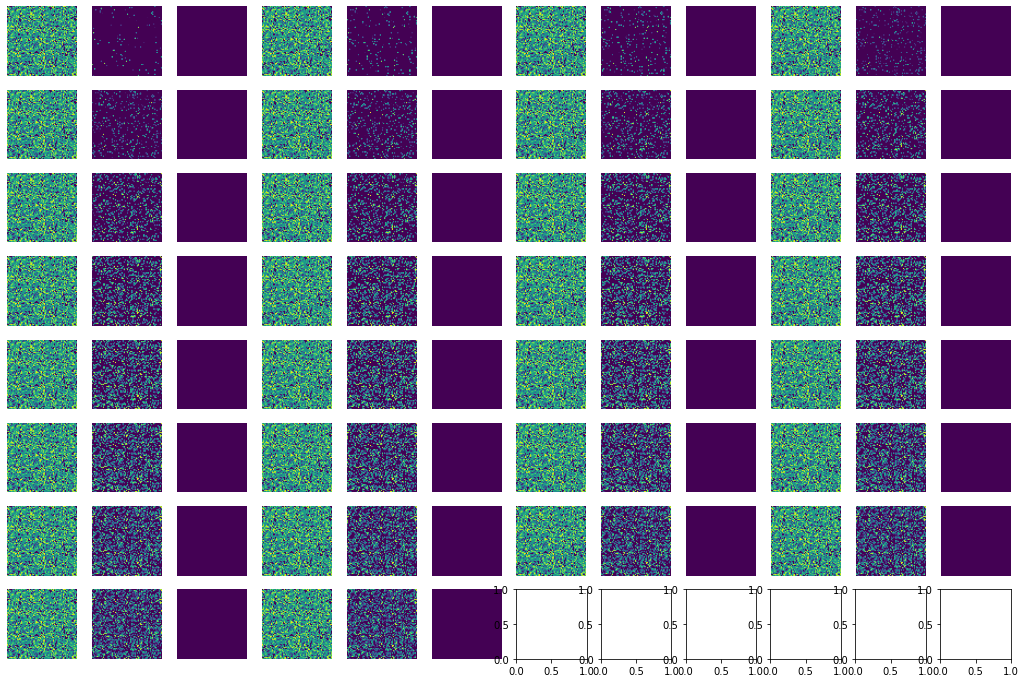

In [ ]:
layer = CriticalLayer0(dict(
        beta=0.5,
        epsilon=0.1,
        alpha=0.005,
        steps_update=100))
a = tf.zeros((1, 64))

a = layer(a)
C_orig = layer.C.numpy()

with jpl.GridPlot(ncols=12, width=18) as grid_plot:
    for _ in range(30):
        a = layer(a)
        
        grid_plot.imshow(layer.C)
        C_diff = C_orig - layer.C
        grid_plot.imshow(tf.nn.relu(C_diff))
        grid_plot.imshow(tf.nn.relu(-C_diff))

## [Criticality meets learning: Criticality signatures in a self-organizing recurrent neural network](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0178683)

The self-organizing recurrent network (SORN) consists of excitatory $x\in\mathbb{R}^{N_E}$ and inhibitory $y\in\mathbb{R}^{N_I}$ neurons ($N_I = 0.2 \times N_E$) connected in a system of boolean update equations with fast and slow acting responses

- excitatory to excitatory connections $W^{EE} \in \mathbb{R}^{N_E \times N_E}$; $w^{EE}_{ij} \sim \mathcal{B}(p=0.1)\mathcal{U}(0, 0.1)$ without self-connections $w^{EE}_{ij}=0 \Leftrightarrow i=j$
- inhibitory to excitatory connections $W^{EI} \in \mathbb{R}^{N_E \times N_I}$; $w^{EI}_{ij} \sim \mathcal{B}(p=0.2)\mathcal{U}(0, 0.1)$ without self-connections $w^{EI}_{ij}=0 \Leftrightarrow i=j$
- excitatory to inhibitory connections $W^{IE} \in \mathbb{R}^{N_I \times N_E}$; $w^{IE}_{ij} \sim \mathcal{U}(0, 0.1)$ without self-connections $w^{IE}_{ij}=0 \Leftrightarrow i=j$
- input noise $\zeta^{E/I} \sim \mathcal{N}(\mu=0, \sigma^2=0.05)$
- external input $u^{ext}(t) = 0\ \mathrm{(default)}$
- excitatory and inhibitory activation thresholds $T^{E/I} \in \mathbb{R}^{N_E/N_I}$; $T^E \sim \mathcal{U}(0, T^E_{max}=0.5)$, $T^I \sim \mathcal{U}(0, T^I_{max}=1.0)$

In [ ]:
SORN_PARAMS = dict(
    T_E_max = ,
    T_I_max = ,
)

SORN = dict(
    N_E = ,
    N_I = ,
    zeta_E_mu = ,
    zeta_I_mu = ,
    zeta_E_s2 = ,
    zeta_I_s2 = ,
    T_E = ,
    T_I = ,
    x = ,
    y = ,
    W_EE = ,
    W_EI = ,
    W_IE = ,

)

### fast-acting behavior

![](https://journals.plos.org/plosone/article/file?type=thumbnail&id=info:doi/10.1371/journal.pone.0178683.e005)

![](https://journals.plos.org/plosone/article/file?type=thumbnail&id=info:doi/10.1371/journal.pone.0178683.e006)

### Slow Adaptations

1. **Spike Timing Dependant Plasticity (STDP)** makes synapse $w^{EE}_{ij}$ decrease when $i$ activates before $j$ (since the connection must've not been important) and increase when $i$ activate after $j$ (since the connection made a significant contribution). It has no effect when one of the values is $0$: $$\Delta w^{EE}_{ij} = \eta_{STDP}[x_i(t)x_j(t-1) - x_j(t)x_i(t-1)]$$

2. **Inhibitory Spike Timing Dependant Plasticity (iSTDP)** increases (decreases) the strength of *existing ($w^{IE}_{ij}>0$)* inhibitory to excitatory connections when they are unsucessful (sucessful) at inhibiting their downstream excitatory neurons. Inhibitory synaptic growth is (target firing rate $\mu_{IP}$ times) slower to strengthen synapses than weaken them: $$\begin{align*}
\Delta w^{IE}_{ij} =& \frac{\eta_{inh}}{\mu_{IP}}x_i(t)y_j(t-1) - \eta_{inh}(1-x_i(t))y_j(t-1) \\
 =& -\eta_{inh}y_j(t-1)[1-x_i(t)(1+1/\mu_{IP})] \end{align*}$$

3. **Synaptic normalization** normalizes input for $W^{EE}$ and $W^{EI}$ to $1$: $$W^{EE/EI}_{ij} \leftarrow W^{EE/EI}_{ij} / \sum_j W^{EE/EI}_{ij}$$

4. **Structural Plasticity (SP)** randomly adds small values synapses ($\eta_{SP}=0.001$) between unconnected neurons by Bernoili probability factor $p_{SP}$ which scales quatratically with respect to the number of nodes $p_{SP}(N^E) = \frac{N^E(N^E-1)}{200(199)}p_{SP}(N^E=200)$ with the base case $p_{SP}(N^E=200) = 0.1$. $$w^{EE/EI}_{ij} \leftarrow \eta_{SP}\mathcal{B}(p_{SP}) \Leftrightarrow w^{EE/EI}_{ij} = 0$$

5. **Intrinsic plasticity (IP)** homeostatically adapts excitatory firing thresholds to maintain a mean firing rate $H_{IP} \sim \mathcal{N}(\mu_{IP}=0.1, \sigma_{IP}^2 = 0)$ $$\Delta T^{E} = \eta_{IP}[x(t) - H_{IP}]$$

Negative ($x<0$), large ($x>1$), and null weights are pruned after each update step. "Assuming one time step equals 10 to 20 ms, these constants resulted in an average firing rate in the 5 − 10 Hz range." (Papa 2017)